# Global ms diagnosis on main combination
- compute MSRe, nMSRe, $C_{\alpha}$, captured physical signal and error parts
- evaluate H1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
from  histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, nMSRe_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
DL =25*1e3 #meters
DT = 1800.0 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'

# Datasets 

In [3]:
dsms = xr.open_dataset(os.path.join(zarr_dir+'_ok','global_minus',f'ms_{int(DL//1000)}_{DT}_drogued_minus.zarr'))
gps = [l for l in dsms.drifter_sat_year.values if 'gps' in l]
dsmean = xr.open_dataset(os.path.join(zarr_dir+'_ok','global_minus',f'mean_{int(DL//1000)}_{DT}_drogued_minus.zarr'))

ds, mslow, msup = global_ms_drifter_sat_year(dsmean.sel(drifter_sat_year=gps), dsms.sel(drifter_sat_year=gps), alpha=0.01)
mserr = (msup-mslow)/2

<xarray.DataArray 'nb_coloc' ()>
array(146030)


In [4]:
dsms.sel(drifter_sat_year='gps_Sentinel-3_A_2019')

<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               id_comb: 80)
Coordinates:
    drifter_sat_year                                                                          <U32 ...
  * id_comb                                                                                   (id_comb) <U75 ...
Data variables: (12/425)
    alti_ggx_adt_filtered                                                                     float64 ...
    alti_ggx_adt_filtered_ocean_tide                                                          float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide                                            float64 ...
    alti_ggx_adt_filtered_ocean_tide_internal_tide_dac                                        float64 ...
    aviso_alti_ggx_adt                                                                        float64 ...
    aviso_drifter_ggx_adt                                                                     float64 ...
    ...                                                                                        ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__alti_x                                 float64 ...
    sum_co__2__adt_filtered_ocean_tide__es_cstrio_z15__drifter_x                              float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x                   float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x                float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__alti_x               float64 ...
    sum_co__2__adt_filtered_ocean_tide_internal_tide_dac__es_cstrio_z15__drifter_x            float64 ...

______________________
# Closure efficiancy : MSRe $\langle S^2 \rangle$ and $nMSRe = \frac{\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
- AVISO more efficient

In [5]:
print('Along-track')
print('MSRe = ' + f"{ds['sum_'+id_co].values,mserr['sum_'+id_co].values }")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_co)}")
print('AVISO')
print('ReMS = ' + f"{ds['sum_'+id_aviso].values, mserr['sum_'+id_aviso].values}")
print(f"nMSRe = {nMSRe_id(ds,mserr, id_aviso)}")

Along-track
MSRe = (array(1.55309182e-10), array(1.48050399e-12))
nMSRe = (array(19.3874156), array(0.36962588))
AVISO
ReMS = (array(1.39110801e-10), array(1.32609095e-12))
nMSRe = (array(20.58652679), array(0.39248724))


Text(0, 0.5, 'MSRE $[m^2/s^4]$')

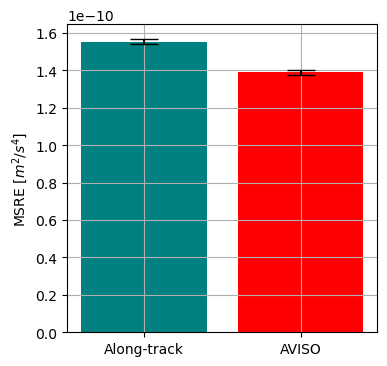

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, ds['sum_'+id_co], yerr =mserr['sum_'+id_co],  color ='teal',width = 0.4, capsize=10)
ax.bar(1, ds['sum_'+id_aviso], yerr =mserr['sum_'+id_aviso], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'MSRE $[m^2/s^4]$')

Text(0, 0.5, '$nMSRe$ [%]')

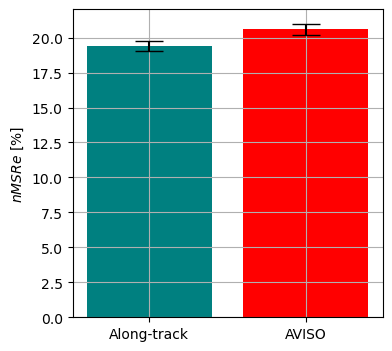

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, nMSRe_id(ds,mserr, id_co)[0],yerr = nMSRe_id(ds,mserr, id_co)[1], color ='teal',width = 0.4, capsize=10)
ax.bar(1, nMSRe_id(ds,mserr, id_aviso)[0], yerr = nMSRe_id(ds, mserr,id_aviso)[1], color ='red',width = 0.4, capsize=10)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$nMSRe$ [%]')

______________________
# $\alpha$ contribution : $C_{\alpha} =\langle S_{-\alpha_i}^2\rangle-\langle S^2 \rangle$ 

In [8]:
CX = C_x(ds,mserr, [id_co, id_aviso])

In [9]:
CX

,acc,coriolis,ggrad,wind,acc_err,coriolis_err,ggrad_err,wind_err
id_comb,,,,,,,,
co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x,6.612105e-11,2.420309e-10,1.708315e-10,1.148061e-11,3.591315e-12,5.268198e-12,4.589481e-12,3.070448e-12
aviso__25__adt__es_cstrio_z15__alti_x,2.389318e-11,1.746366e-10,1.870299e-10,1.195582e-11,2.879947e-12,4.316927e-12,4.435068e-12,2.766152e-12


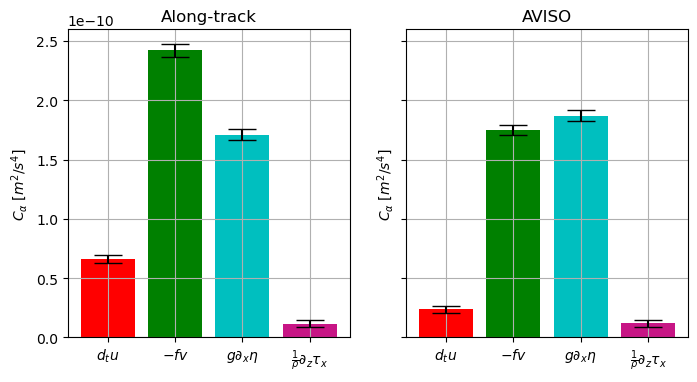

In [10]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,4), sharey=True)
ax=axs[0]
df = CX.loc[id_co]
ax.bar(0.5, df.acc, yerr=df.acc_err, color ='r',width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color ='g',width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color ='c',width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color ='mediumvioletred',width = 0.4, capsize=10)
ax.set_title('Along-track')

ax=axs[1]
df = CX.loc[id_aviso]
ax.bar(0.5, df.acc,yerr=df.acc_err, color ='r',width = 0.4, capsize=10)
ax.bar(1, df.coriolis,yerr=df.coriolis_err, color ='g',width = 0.4, capsize=10)
ax.bar(1.5, df.ggrad,yerr=df.ggrad_err, color ='c',width = 0.4, capsize=10)
ax.bar(2, df.wind,yerr=df.wind_err, color ='mediumvioletred',width = 0.4, capsize=10)
ax.set_title('AVISO')

for ax in axs :
    ax.grid()
    ticks = (r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks([0.5, 1, 1.5, 2], ticks,)
    ax.set_ylabel(r'$C_{\alpha}$ $[m^2/s^4]$')
    

acc:1.0225340944701955e-10, coriolis:3.685598075041293e-10, ggrad:3.122782341767954e-10, wind:1.7990986956477548e-11
acc:1.0225340944701955e-10, coriolis:3.685598075041293e-10, ggrad:1.8693290441633343e-10, wind:1.7990986956477548e-11


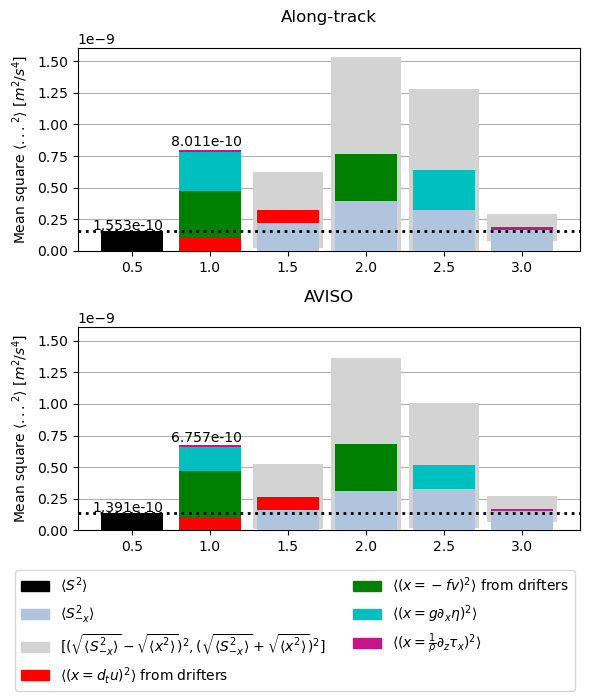

In [11]:
fig_title=1
fig, axs = plt.subplots(nrows=2,ncols=1,
                            sharey='all',
                            figsize=(6,7))
plot_closure_bar(ds, id_co ,axs[0], title = 'Along-track')
plot_closure_bar(ds, id_aviso,axs[1], title = 'AVISO')


if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
fig.legend(handles, labels_, ncol=2,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.18,1,1])#left, bottom, right, top (default is 0,0,1,1)

________________________
# True/Error in $\alpha$ 
$\langle \hat{\alpha_i} \rangle +\langle \hat{\alpha_i}{\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle - \langle S^2 \rangle +\langle S_{-\alpha_i}^2 \rangle) $  

$\langle {\alpha_i^{e}}^2 \rangle+\langle \hat{\alpha_i}{\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle + \langle S^2 \rangle -\langle S_{-\alpha_i}^2 \rangle) $
## Under H1

$\langle \hat{\alpha_i} \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle - \langle S^2 \rangle +\langle S_{-\alpha_i}^2 \rangle) $  

$\langle {\alpha_i^{e}}^2 \rangle  = \frac{1}{2}(\langle \alpha_i^2 \rangle + \langle S^2 \rangle -\langle S_{-\alpha_i}^2 \rangle) $

In [12]:
dsms = xr.concat([true_err_x(ds,mserr, id_co), true_err_x(ds,mserr, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [13]:
dsms

<xarray.Dataset>
Dimensions:            (id_comb: 2)
Coordinates:
  * id_comb            (id_comb) object 'co__25__adt_filtered_ocean_tide_inte...
Data variables: (12/29)
    acc                (id_comb) float64 1.023e-10 1.023e-10
    acc_err            (id_comb) float64 9.747e-13 9.747e-13
    exc_acc            (id_comb) float64 2.214e-10 1.63e-10
    true_acc           (id_comb) float64 8.419e-11 6.307e-11
    true_acc_err       (id_comb) float64 2.283e-12 1.927e-12
    err_acc            (id_comb) float64 1.807e-11 3.918e-11
    ...                 ...
    exc_wind           (id_comb) float64 1.668e-10 1.511e-10
    true_wind          (id_comb) float64 1.474e-11 1.497e-11
    true_wind_err      (id_comb) float64 1.621e-12 1.469e-12
    err_wind           (id_comb) float64 3.255e-12 3.018e-12
    err_wind_err       (id_comb) float64 1.621e-12 1.469e-12
    S                  (id_comb) float64 1.553e-10 1.391e-10

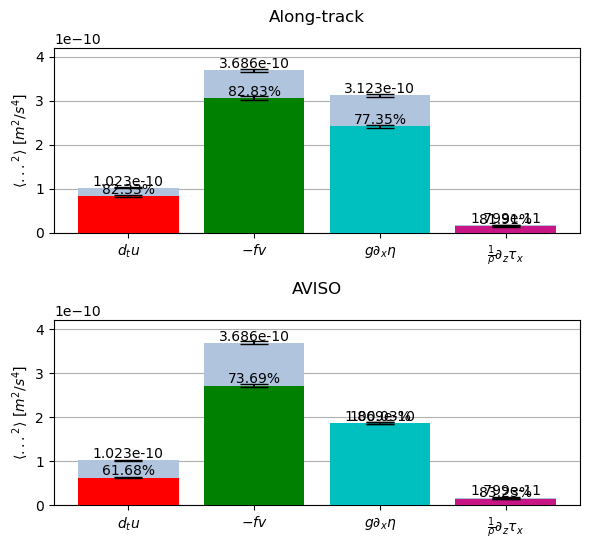

In [14]:
fig_title=1
fig, axs = plt.subplots(nrows=2,ncols=1,
                            sharey='all',
                            figsize=(6,7))
plot_cor_uncor_part(dsms.sel(id_comb=id_co), ax=axs[0], title ='Along-track')
plot_cor_uncor_part(dsms.sel(id_comb=id_aviso), ax=axs[1], title ='AVISO')
axs[0].set_ylim(0,4.2e-10)
axs[0].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
axs[1].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

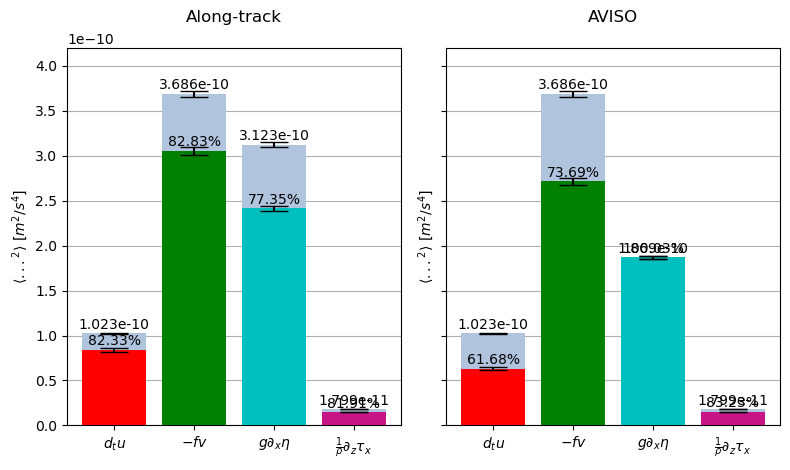

In [15]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(8,6))
plot_cor_uncor_part(dsms.sel(id_comb=id_co), ax=axs[0], title ='Along-track')
plot_cor_uncor_part(dsms.sel(id_comb=id_aviso), ax=axs[1], title ='AVISO')
axs[0].set_ylim(0,4.2e-10)
axs[0].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
axs[1].set_ylabel(r'$\langle ...^2 \rangle$ $[m^2/s^4]$')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

## Validité erreurs non corrélées :

- erreurs coriolis/acceleration doivent être correlées -> possible de le voir ?


$$ \langle S^2 \rangle - \sum_i A_{x_i} = \sum_x \langle \hat{x}x_e \rangle + \sum_i\sum_{j\neq i}[\langle {x_e}_i{x_e}_j \rangle + 2\langle {x_e}_i\hat{x}_j \rangle + \langle \hat{x}_i{x_e}_j \rangle] $$

In [16]:
dsmm = dsms*1e10

In [17]:
A = dsmm['err_acc']+dsmm['err_ggrad']+dsmm['err_wind']+dsmm['err_coriolis']

In [18]:
((A-dsmm['S'])/dsmm['S'])

<xarray.DataArray (id_comb: 2)>
array([-2.8593880e-16, -3.1923417e-16])
Coordinates:
  * id_comb  (id_comb) object 'co__25__adt_filtered_ocean_tide_internal_tide_...

In [19]:
dsmm['S']

<xarray.DataArray 'S' (id_comb: 2)>
array([1.55309182, 1.39110801])
Coordinates:
  * id_comb  (id_comb) object 'co__25__adt_filtered_ocean_tide_internal_tide_...

______________
# Wind term estimation error part

In [20]:
dsms

<xarray.Dataset>
Dimensions:            (id_comb: 2)
Coordinates:
  * id_comb            (id_comb) object 'co__25__adt_filtered_ocean_tide_inte...
Data variables: (12/29)
    acc                (id_comb) float64 1.023e-10 1.023e-10
    acc_err            (id_comb) float64 9.747e-13 9.747e-13
    exc_acc            (id_comb) float64 2.214e-10 1.63e-10
    true_acc           (id_comb) float64 8.419e-11 6.307e-11
    true_acc_err       (id_comb) float64 2.283e-12 1.927e-12
    err_acc            (id_comb) float64 1.807e-11 3.918e-11
    ...                 ...
    exc_wind           (id_comb) float64 1.668e-10 1.511e-10
    true_wind          (id_comb) float64 1.474e-11 1.497e-11
    true_wind_err      (id_comb) float64 1.621e-12 1.469e-12
    err_wind           (id_comb) float64 3.255e-12 3.018e-12
    err_wind_err       (id_comb) float64 1.621e-12 1.469e-12
    S                  (id_comb) float64 1.553e-10 1.391e-10

In [21]:
ds.es_cstrio_z15_alti_wd_x/ds['sum_'+id_co]*100

<xarray.DataArray ()>
array(11.58398156)

In [22]:
(ds['exc_wind_'+id_co]-ds['sum_'+id_co])/ds['sum_'+id_co]*100

<xarray.DataArray ()>
array(7.39209919)

In [23]:
ds.es_cstrio_z15_alti_wd_x

<xarray.DataArray 'es_cstrio_z15_alti_wd_x' ()>
array(1.7990987e-11)
Attributes:
    description:  along track wind related term interpolated at the altimeter...
    long_name:    $(-\frac{1}{\rho}\partial_z\tau_x)_{altimatchup}$ from cstr...
    units:        $m^2.s^{-4}$

In [24]:
ds['sum_'+id_co]

<xarray.DataArray 'sum_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x' ()>
array(1.55309182e-10)
Attributes:
    acc:          drifter_acc_x_25
    coriolis:     drifter_coriolis_x_25
    description:  acc+coriolis+ggrad+wind
    ggrad:        alti_ggx_adt_filtered_ocean_tide_internal_tide
    long_name:    $d_tu$+$-fv$+$g\partial_x$adt_filtered+$(-\frac{1}{\rho}\pa...
    units:        $m^2.s^{-4}$
    wind:         es_cstrio_z15_alti_wd_x

In [25]:
ds['exc_wind_'+id_co]

<xarray.DataArray 'exc_wind_co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x' ()>
array(1.6678979e-10)
Attributes:
    acc:          drifter_acc_x_25
    coriolis:     drifter_coriolis_x_25
    description:  acc+coriolis+ggrad
    ggrad:        alti_ggx_adt_filtered_ocean_tide_internal_tide
    long_name:    $d_tu$+$-fv$+$g\partial_x$adt_filtered
    units:        $m^2.s^{-4}$
    wind:         es_cstrio_z15_alti_wd_x